# Предсказательная модель честности отеля по отзывам. 
Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Вам поставлена задача создать такую модель. 

In [45]:
# импортируем библиотеки

import numpy as np 
import pandas as pd 
import sklearn
import osmnx as ox
import re
# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
import time
import plotly.express as px


# библиотеки для создания и обучения модели
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Импортируем библиотеки, необходимые для преобразования признаков
import category_encoders as ce
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from geopy.distance import geodesic as GD 
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import geopy


# 1. Исследование структуры данных

Первоначальная версия датасета содержит 17 полей со следующей информацией:

- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.

In [46]:
#Читаем данные и смотрим пример данных
data = pd.read_csv('data/hotels.csv')
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


1.1 Выведим основную информацию о числе непустых значений в столбцах и их типах в таблице.

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

1.2 Выведим основную статистическую информацию о столбцах.

In [48]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.00000,386803.000000,384355.000000,384355.000000
mean,498.246536,8.397231,18.538988,2743.992042,17.776985,7.17725,8.396906,49.443522,2.823402
std,500.258012,0.547881,29.703369,2316.457018,21.726141,11.05442,1.636090,3.466936,4.579043
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.00000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.00000,7.500000,48.214662,-0.143649
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.00000,8.800000,51.499981,-0.000250
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.00000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.00000,10.000000,52.400181,16.429233


1.3 Посмотрим на пропуски в данных.

In [49]:
# Вычисляем количество пропусков в каждом столбце
missing_values = data.isnull().sum()

# Выводим столбцы с пропусками
print("Пропуски данных в столбцах:")
print(missing_values)

Пропуски данных в столбцах:
hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
dtype: int64


Заполним пропуски

In [50]:
# Инициализация геокодера
geolocator = Nominatim(user_agent="ivan.monakov90@gmail.com")


# Заполнение пропущенных координат
def fill_missing_coordinates(data):
    # Заполняем NaN значениями 0 в колонках lat и lng
    data[['lat', 'lng']] = data[['lat', 'lng']].fillna(0)

    # Фильтруем отели, у которых координаты отсутствуют (lat или lng равны 0)
    mask = (data['lat'] == 0) | (data['lng'] == 0)
    hotel_none = data[mask]

    # Список уникальных отелей и их адресов
    hotel_list = hotel_none.hotel_name.value_counts().index.to_list()
    hotel_adr = hotel_none.hotel_address.value_counts().index.to_list()

    # Цикл по отелям без координат
    for h, a in zip(hotel_list, hotel_adr):
        try:
            # Извлекаем последние 4 элемента адреса (почтовый индекс, город, страна)
            a_parts = a.split(' ')[-4:]
            a_query = ' '.join(a_parts)

            # Геокодируем адрес
            place = geolocator.geocode(a_query, exactly_one=True, language='en')
            if place is not None:
                # Обновляем координаты в DataFrame
                data.loc[data['hotel_name'].eq(h) & data['lat'].eq(0), 'lat'] = place.latitude
                data.loc[data['hotel_name'].eq(h) & data['lng'].eq(0), 'lng'] = place.longitude
                print(f"Updated: {h} -> Lat: {place.latitude}, Lng: {place.longitude}")
            else:
                print(f"Not found: {h} -> Address: {a_query}")
        except Exception as e:
            print(f"Error with {h}: {e}")

        # Пауза между запросами, чтобы избежать блокировки
        time.sleep(1)

    return data

# Применяем
if __name__ == "__main__":
    
    data = fill_missing_coordinates(data)

data.info()

 

Updated: Fleming s Selection Hotel Wien City -> Lat: 48.2108819, Lng: 16.347368670535193
Updated: Hotel City Central -> Lat: 48.2006384, Lng: 16.426895311477978
Updated: Hotel Atlanta -> Lat: 48.22507295, Lng: 16.35839764159848
Updated: Maison Albar Hotel Paris Op ra Diamond -> Lat: 48.8870221, Lng: 2.3478318
Updated: Hotel Daniel Vienna -> Lat: 48.20254735, Lng: 16.384617023716054
Updated: Hotel Pension Baron am Schottentor -> Lat: 48.22507295, Lng: 16.35839764159848
Updated: Austria Trend Hotel Schloss Wilhelminenberg Wien -> Lat: 48.2149546, Lng: 16.302153494876826
Updated: NH Collection Barcelona Podium -> Lat: 41.3936885, Lng: 2.1636552
Updated: Derag Livinghotel Kaiser Franz Joseph Vienna -> Lat: 48.2048346, Lng: 16.3702081
Updated: City Hotel Deutschmeister -> Lat: 48.22507295, Lng: 16.35839764159848
Updated: Holiday Inn Paris Montmartre -> Lat: 48.8870221, Lng: 2.3478318
Updated: Hotel Park Villa -> Lat: 48.2048346, Lng: 16.3702081
Updated: Cordial Theaterhotel Wien -> Lat: 48.

1.4 Посмотрим на количество уникальных значений в каждом из признаков.

In [51]:
# Получаем количество уникальных значений для каждого признака
unique_values_count = data.nunique()

# Выводим результат
print(unique_values_count)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             225
negative_review                               248828
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               311737
review_total_positive_word_counts                354
total_number_of_reviews_reviewer_has_given       194
reviewer_score                                    37
tags                                           47135
days_since_review                                731
lat                                             1481
lng                                             1481
dtype: int64


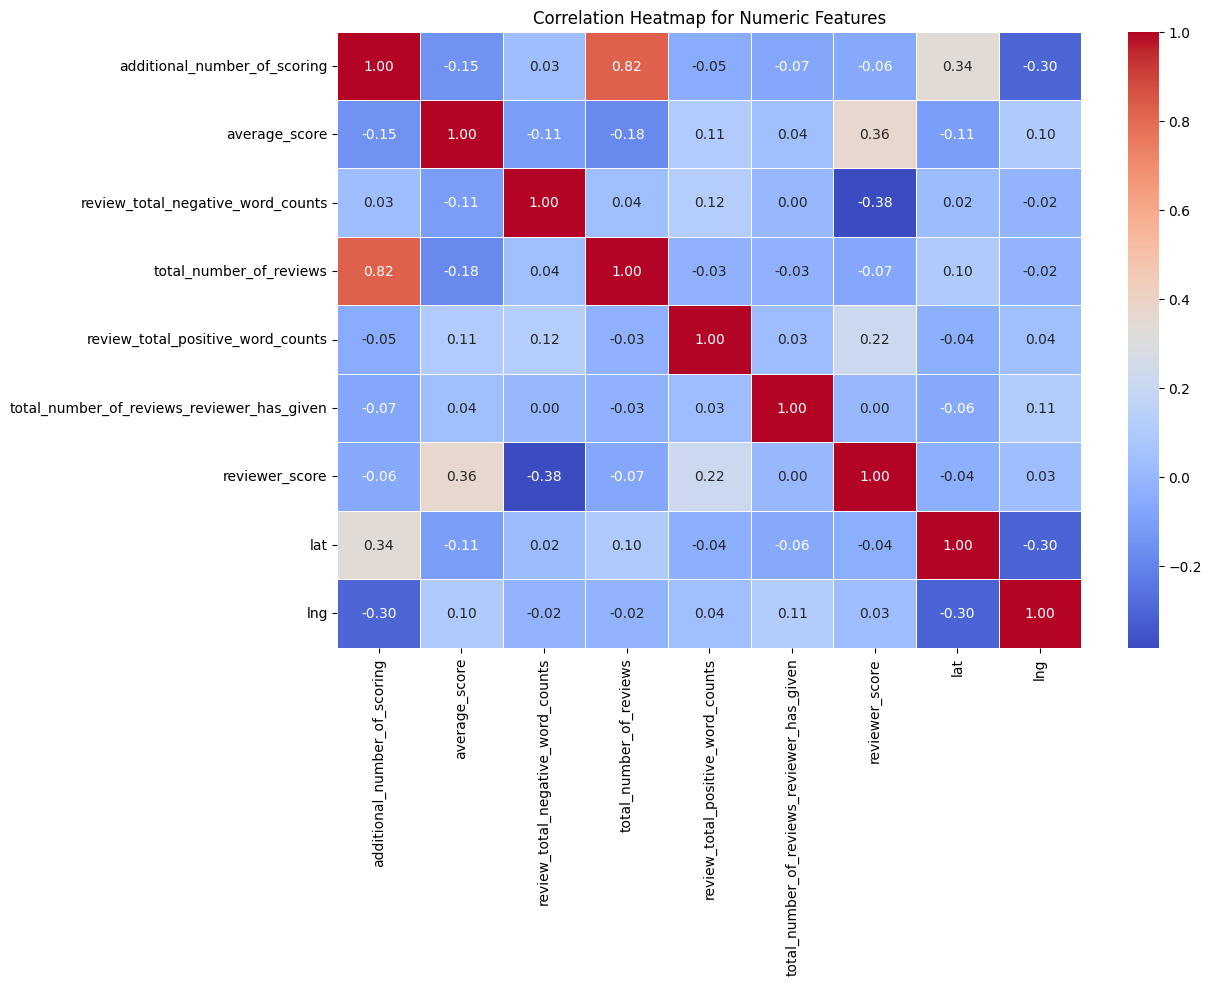

In [52]:
# Выбираем только числовые столбцы
numeric_data = data.select_dtypes(include=['number'])

# Вычисляем корреляцию
correlation_matrix = numeric_data.corr()

# Построение тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap for Numeric Features")
plt.show()

Наблюдается сильная корреляция между признаками total_number_of_reviews и additional_number_of_scoring. Нужно удалить один из них.

In [53]:
# Удалим признак additional_number_of_scoring.
data = data.drop('additional_number_of_scoring', axis=1)
data.head(4)

,hotel_address,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540


# 2. Преобразование данных

2.1 Преобразуем строку в 'days_since_review' в число.

In [54]:

# Извлекаем только числовые значения из строк и преобразуем в int
data['days_since_review'] = data['days_since_review'].str.extract('(\d+)').astype(int)

# Проверка результата
print(data['days_since_review'].head())


0    531
1    203
2    289
3    681
4    516
Name: days_since_review, dtype: int32


2.2 От даты написания отзыва оставим только месяц. Поскольку мы не привязаны к какому либо временному промежутку, но может прослеживаться различный характер отзывов в зависимости от времени года.
Закодируем 'review_date' в отдельные признаки месяц, зима, весна, лето, осень.

In [55]:
# Преобразуем столбец 'review_date' в формат datetime, если это ещё не сделано
data['review_date'] = pd.to_datetime(data['review_date'], errors='coerce')

# Создаём признак месяц
data['month'] = data['review_date'].dt.month


# Создаём бинарные признаки для сезонов
def get_season(month):
    """
    Возвращает название сезона в зависимости от месяца:
    1-2, 12 -> зима; 3-5 -> весна; 6-8 -> лето; 9-11 -> осень.
    """
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'

# Присваиваем сезон каждому месяцу
data['season'] = data['month'].apply(get_season)

# Создаём бинарные признаки для каждого сезона
data['is_spring'] = (data['season'] == 'spring').astype(int)
data['is_summer'] = (data['season'] == 'summer').astype(int)
data['is_autumn'] = (data['season'] == 'autumn').astype(int)
data['is_winter'] = (data['season'] == 'winter').astype(int)

# Удалим исходный столбец.
data= data.drop('review_date', axis=1)

data[['month', 'is_spring', 'is_summer', 'is_autumn', 'is_winter']].head()

,month,is_spring,is_summer,is_autumn,is_winter
0,2,0,0,0,1
1,1,0,0,0,1
2,10,0,0,1,0
3,9,0,0,1,0
4,3,1,0,0,0


In [56]:
#обработаем месяцы OneHotEncoderom, создав 12 новых признаков в бинарном формате.
encoder = ce.OneHotEncoder(cols=['month']) # указываем столбец для кодирования.
type_bin = encoder.fit_transform(data['month'])
data = pd.concat([data, type_bin], axis=1).reset_index()
data = data.drop('month', axis=1)
data.shape

c:\Users\monak\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\monak\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\monak\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\ordinal.py:198: FutureWa

(386803, 33)

In [57]:
# Удалим признак времени года
data = data.drop('season', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   index                                       386803 non-null  int64  
 1   hotel_address                               386803 non-null  object 
 2   average_score                               386803 non-null  float64
 3   hotel_name                                  386803 non-null  object 
 4   reviewer_nationality                        386803 non-null  object 
 5   negative_review                             386803 non-null  object 
 6   review_total_negative_word_counts           386803 non-null  int64  
 7   total_number_of_reviews                     386803 non-null  int64  
 8   positive_review                             386803 non-null  object 
 9   review_total_positive_word_counts           386803 non-null  int64  
 

2.3 Добавим признаки городов где рассположен отель.
Добавлять признак страны не будем, иначе он будет сильно коррелировать с признаками городов.

In [58]:
# Извлечение города с использованием функции
def get_city(arg):
    if arg.split()[-2] == 'United':
        return arg.split()[-5]
    else:
        return arg.split()[-2]
data['city'] = data['hotel_address'].apply(get_city)

# Применение бинарного кодирования (One-Hot-Encoding)
city_dummies = pd.get_dummies(data['city'], prefix='city', dtype=int)

# Объединение с оригинальным DataFrame
data = pd.concat([data, city_dummies], axis=1)

# Печать результата
data.head(3)

,index,hotel_address,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,month_10,month_11,month_12,city,city_Amsterdam,city_Barcelona,city_London,city_Milan,city_Paris,city_Vienna
0,0,Stratton Street Mayfair Westminster Borough Lo...,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,...,0,0,0,London,0,0,1,0,0,0
1,1,130 134 Southampton Row Camden London WC1B 5AF...,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,...,0,0,0,London,0,0,1,0,0,0
2,2,151 bis Rue de Rennes 6th arr 75006 Paris France,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,...,0,0,0,Paris,0,0,0,0,1,0


Удалим исходные столбцы 

In [ ]:
data = data.drop(['hotel_address','city'], axis=1)
data.info()


2.4 Рассмотрим признак hotel_name.

C:\Users\monak\AppData\Local\Temp\ipykernel_19696\1335549060.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hotel_counts.index, y=hotel_counts.values, palette="viridis")


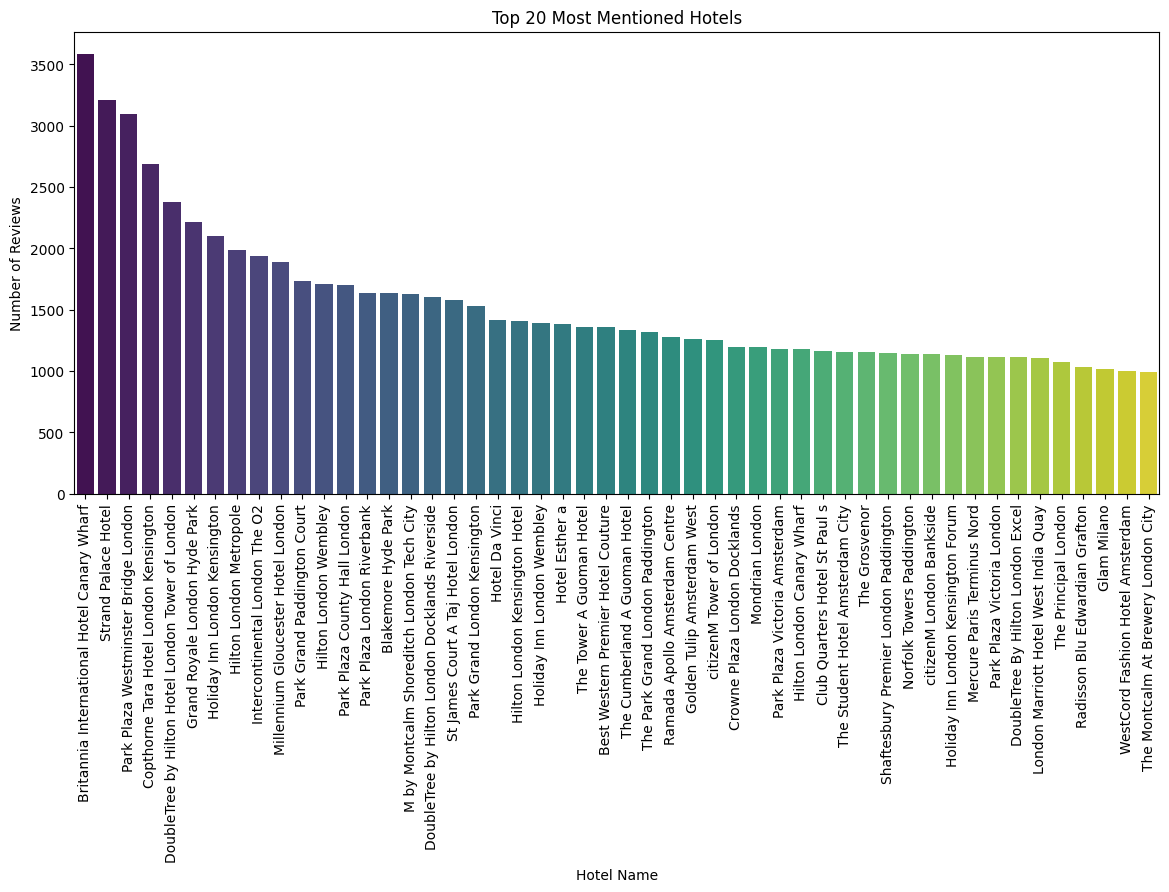

In [ ]:
# Считаем количество упоминаний каждого отеля
hotel_counts = data['hotel_name'].value_counts().head(50)  # Топ-50

# Построение графика
plt.figure(figsize=(14, 6))
sns.barplot(x=hotel_counts.index, y=hotel_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Hotel Name")
plt.ylabel("Number of Reviews")
plt.title("Top 50 Most Mentioned Hotels")
plt.show()

Можно создать бинарные признаки для топ-10 популярных отелей, а остальные объединить в категорию others.

In [65]:
# Получаем список топ-10 отелей
top_10_hotels = data['hotel_name'].value_counts().head(10).index

# Создаем новый признак, где популярные отели сохраняем, а остальные заменяем на 'others'
data['hotel_category'] = data['hotel_name'].apply(lambda x: x if x in top_10_hotels else 'others')

# Кодируем признак в бинарные колонки
hotel_dummies = pd.get_dummies(data['hotel_category'], prefix='hotel', dtype=int)

# Добавляем в DataFrame
data = pd.concat([data, hotel_dummies], axis=1)

# Проверяем результат
data.head()

,index,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,hotel_Copthorne Tara Hotel London Kensington,hotel_DoubleTree by Hilton Hotel London Tower of London,hotel_Grand Royale London Hyde Park,hotel_Hilton London Metropole,hotel_Holiday Inn London Kensington,hotel_Intercontinental London The O2,hotel_Millennium Gloucester Hotel London,hotel_Park Plaza Westminster Bridge London,hotel_Strand Palace Hotel,hotel_others
0,0,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,...,0,0,0,0,0,0,0,0,0,1
1,1,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,...,0,0,0,0,0,0,0,0,0,1
2,2,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,...,0,0,0,0,0,0,0,0,0,1
3,3,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,...,0,0,0,0,0,0,0,0,0,1
4,4,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,...,0,0,0,0,0,0,0,0,0,1


Удаляем признак hotel_name.

In [66]:
data = data.drop(columns=['hotel_name'])

2.5 Изучим теги

In [67]:
# Получаем и выводим самые популярные теги
popular_tags = data['tags'].value_counts().tail(30)  # Покажем 10 самых популярных тегов
popular_tags

tags
[' Leisure trip ', ' Family with older children ', ' Premier Double Room ', ' Stayed 5 nights ', ' Submitted from a mobile device ']                                 1
[' Leisure trip ', ' Family with older children ', ' Triple Room Luxury XXL King Size Bed ', ' Stayed 3 nights ']                                                    1
[' Business trip ', ' Solo traveler ', ' Classic Double Single Use ', ' Stayed 2 nights ']                                                                           1
[' Leisure trip ', ' Couple ', ' Park Queen ', ' Stayed 1 night ', ' Submitted from a mobile device ']                                                               1
[' Leisure trip ', ' Family with young children ', ' Triple Junior Suite ', ' Stayed 2 nights ']                                                                     1
[' Leisure trip ', ' Group ', ' Superior Double or Twin Room 1 2 Adults ', ' Stayed 9 nights ', ' Submitted from a mobile device ']                             

In [69]:
# Преобразуем тег в числовое значение количества ночей
def extract_nights(tag):
    match = re.search(r'Stayed (\d+) night', tag)
    if match:
        return int(match.group(1))
    return None

# Применим функцию к столбцу 'tags'
data['nights'] = data['tags'].apply(extract_nights)

# Создаём бинарные признаки для каждой ночи с 1 по 14
for night in range(1, 8):
    data[f'stay_{night}_night'] = data['nights'].apply(lambda x: 1 if x == night else 0)

# Создаём бинарные признаки для больше 14 ночей (long_stand)

data['long_stand'] = data['nights'].apply(lambda x: 1 if x > 14 else 0)

# Печатаем несколько строк для проверки
data[['nights'] + [f'stay_{night}_night' for night in range(1, 8)] + ['long_stand']].head()



,nights,stay_1_night,stay_2_night,stay_3_night,stay_4_night,stay_5_night,stay_6_night,stay_7_night,long_stand
0,2.0,0,1,0,0,0,0,0,0
1,1.0,1,0,0,0,0,0,0,0
2,3.0,0,0,1,0,0,0,0,0
3,1.0,1,0,0,0,0,0,0,0
4,6.0,0,0,0,0,0,1,0,0


In [70]:
data = data.drop(columns=['nights'])

In [71]:
# Создаём бинарные признаки для каждого из тегов
data['leisure_trip'] = data['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
data['couple'] = data['tags'].apply(lambda x: 1 if 'Couple' in x else 0)
data['business trip'] = data['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)
data['solo traveler'] = data['tags'].apply(lambda x: 1 if 'Solo traveler' in x else 0)
data['young children'] = data['tags'].apply(lambda x: 1 if 'Family with young children' in x else 0)
data['older children'] = data['tags'].apply(lambda x: 1 if 'Family with older children' in x else 0)
data['group'] = data['tags'].apply(lambda x: 1 if 'Group' in x else 0)
# Печатаем несколько строк для проверки
data[['leisure_trip', 'couple', 'business trip', 'solo traveler', 'young children','older children', 'group']].head()

,leisure_trip,couple,business trip,solo traveler,young children,older children,group
0,1,1,0,0,0,0,0
1,0,1,1,0,0,0,0
2,1,0,0,1,0,0,0
3,1,0,0,1,0,0,0
4,0,1,1,0,0,0,0


2.6 У нас есть 225 уникальных значений для 'reviewer_nationality'. Давайте присвоим им уникальные числовые значения.

C:\Users\monak\AppData\Local\Temp\ipykernel_19696\3967239990.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=nationality_counts.index, x=nationality_counts.values, palette="viridis")


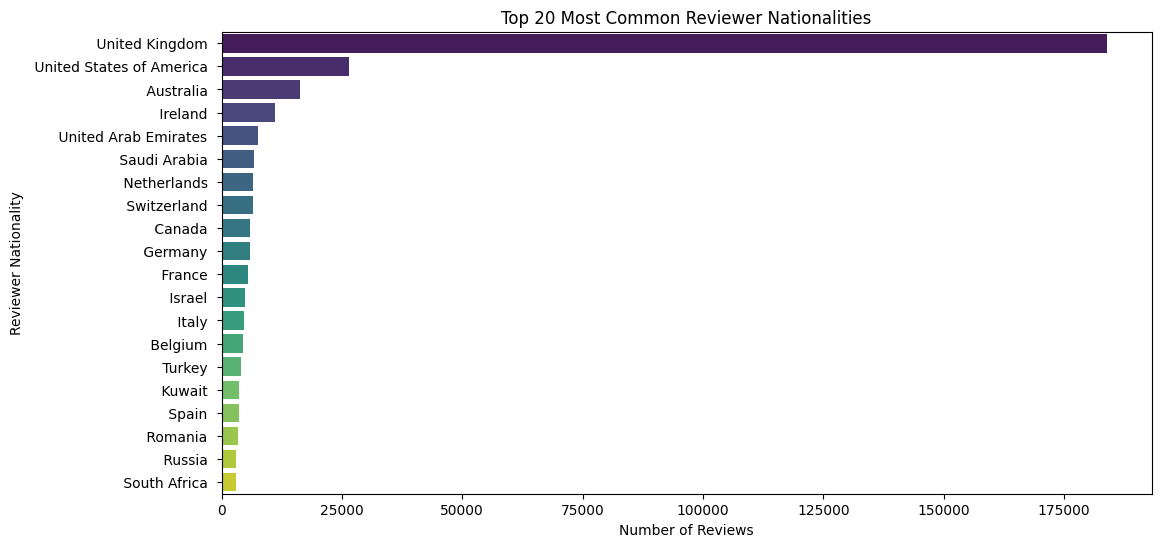

In [72]:
# Считаем количество отзывов от каждой национальности
nationality_counts = data['reviewer_nationality'].value_counts().head(20)  # Топ-20

# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(y=nationality_counts.index, x=nationality_counts.values, palette="viridis")
plt.xlabel("Number of Reviews")
plt.ylabel("Reviewer Nationality")
plt.title("Top 20 Most Common Reviewer Nationalities")
plt.show()

In [73]:
# Определяем топ-N наиболее распространенных национальностей
top_nationalities = data['reviewer_nationality'].value_counts().head(10).index

# Создаем новый признак, где редкие национальности заменяются на 'others'
data['nationality_grouped'] = data['reviewer_nationality'].apply(lambda x: x if x in top_nationalities else 'others')

# Кодируем сокращенный список национальностей в бинарные признаки
nationality_dummies = pd.get_dummies(data['nationality_grouped'], prefix='nationality', dtype=int)

# Объединяем с DataFrame
data = pd.concat([data, nationality_dummies], axis=1)

# Удаляем оригинальный признак
data = data.drop(columns=['reviewer_nationality'])



In [75]:
data = data.drop(columns=['nationality_grouped'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 73 columns):
 #   Column                                                   Non-Null Count   Dtype  
---  ------                                                   --------------   -----  
 0   index                                                    386803 non-null  int64  
 1   average_score                                            386803 non-null  float64
 2   negative_review                                          386803 non-null  object 
 3   review_total_negative_word_counts                        386803 non-null  int64  
 4   total_number_of_reviews                                  386803 non-null  int64  
 5   positive_review                                          386803 non-null  object 
 6   review_total_positive_word_counts                        386803 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given               386803 non-null  int64  
 8   reviewer_score

2.4 Создадим новый признак количества tags в отзыве.

In [15]:
# Шаг 1: Разделяем строку с тегами на список тегов
data['tags_count'] = data['tags'].str.split(',').apply(len)

# Проверка результата
print(data[['tags', 'tags_count']].head())


                                                tags  tags_count
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           5
1  [' Business trip ', ' Couple ', ' Standard Dou...           4
2  [' Leisure trip ', ' Solo traveler ', ' Modern...           5
3  [' Leisure trip ', ' Solo traveler ', ' Standa...           4
4  [' Business trip ', ' Couple ', ' Standard Dou...           4


### Признак процент настоящих отзывов от общего числа отзывов.

In [16]:
# Признак процент настоящих отзывов от общего числа отзывов.
data['percent_real_review'] = round(data['additional_number_of_scoring'] / data['total_number_of_reviews'] * 100,2)
data['percent_real_review']

0         29.14
1         21.97
2          7.88
3          5.60
4         12.05
          ...  
386798    17.34
386799     8.44
386800    16.61
386801    23.29
386802    18.36
Name: percent_real_review, Length: 386803, dtype: float64

### Признак национальность гостя.

In [17]:
data['reviewer_nationality']

0                United Kingdom 
1                United Kingdom 
2                         China 
3                United Kingdom 
4                        Poland 
                   ...          
386798                   France 
386799                   Turkey 
386800              Netherlands 
386801     United Arab Emirates 
386802                Australia 
Name: reviewer_nationality, Length: 386803, dtype: object

In [18]:
popular_nationality = data['reviewer_nationality'].value_counts().nlargest(55).index
popular_nationality

Index([' United Kingdom ', ' United States of America ', ' Australia ',
       ' Ireland ', ' United Arab Emirates ', ' Saudi Arabia ',
       ' Netherlands ', ' Switzerland ', ' Canada ', ' Germany ', ' France ',
       ' Israel ', ' Italy ', ' Belgium ', ' Turkey ', ' Kuwait ', ' Spain ',
       ' Romania ', ' Russia ', ' South Africa ', ' China ', ' Sweden ',
       ' India ', ' Greece ', ' New Zealand ', ' Singapore ', ' Hong Kong ',
       ' Poland ', ' Qatar ', ' Austria ', ' Egypt ', ' Norway ',
       ' Czech Republic ', ' Lebanon ', ' Hungary ', ' Malaysia ',
       ' Thailand ', ' Brazil ', ' Portugal ', ' Finland ', ' Denmark ',
       ' Malta ', ' Bahrain ', ' Indonesia ', ' Oman ', ' Luxembourg ',
       ' Croatia ', ' Bulgaria ', ' Cyprus ', ' Japan ', ' Serbia ', ' Iran ',
       ' Ukraine ', ' Philippines ', ' South Korea '],
      dtype='object', name='reviewer_nationality')

In [19]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in popular_nationality else 'other')
data['reviewer_nationality'].value_counts()

reviewer_nationality
 United Kingdom               184033
 United States of America      26541
 Australia                     16239
other                          15535
 Ireland                       11126
 United Arab Emirates           7617
 Saudi Arabia                   6722
 Netherlands                    6608
 Switzerland                    6498
 Canada                         5984
 Germany                        5956
 France                         5543
 Israel                         4918
 Italy                          4562
 Belgium                        4529
 Turkey                         4105
 Kuwait                         3702
 Spain                          3529
 Romania                        3425
 Russia                         2953
 South Africa                   2888
 China                          2564
 Sweden                         2562
 India                          2559
 Greece                         2536
 New Zealand                    2445
 Singapore       

In [20]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

### Преобразование признаков 'positive_review' и 'negative_review'

In [21]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\monak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [22]:
data['scores_negative'] = data['negative_review'].apply(lambda negative_review: sid.polarity_scores(negative_review))
data['scores_positive'] = data['positive_review'].apply(lambda positive_review: sid.polarity_scores(positive_review))
data['scores_negative']

0         {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1         {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...
2         {'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'comp...
3         {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
4         {'neg': 0.667, 'neu': 0.333, 'pos': 0.0, 'comp...
                                ...                        
386798    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
386799    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
386800    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
386801    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
386802    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: scores_negative, Length: 386803, dtype: object

In [23]:
# обрабатываем неготивные отзыва
data['negative_neg'] = data['scores_negative'].apply(lambda arg: list((arg).values())[0])
data['negative_neu'] = data['scores_negative'].apply(lambda arg: list((arg).values())[1])
data['negative_pos'] = data['scores_negative'].apply(lambda arg: list((arg).values())[2])
data['negative_compound'] = data['scores_negative'].apply(lambda arg: list((arg).values())[-1])

# обрабатываем позитивные отзывы
data['positive_neg'] = data['scores_positive'].apply(lambda arg: list((arg).values())[0])
data['positive_neu'] = data['scores_positive'].apply(lambda arg: list((arg).values())[1])
data['positive_pos'] = data['scores_positive'].apply(lambda arg: list((arg).values())[2])
data['positive_compound'] = data['scores_positive'].apply(lambda arg: list((arg).values())[-1])

In [24]:
data

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,scores_negative,scores_positive,negative_neg,negative_neu,negative_pos,negative_compound,positive_neg,positive_neu,positive_pos,positive_compound
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.345, 'pos': 0.655, 'comp...",0.000,1.000,0.0,0.0000,0.000,0.345,0.655,0.5859
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,"{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.756,0.244,0.0,-0.4767,0.000,1.000,0.000,0.0000
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,"{'neg': 0.423, 'neu': 0.577, 'pos': 0.0, 'comp...","{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...",0.423,0.577,0.0,-0.2960,0.379,0.000,0.621,0.3400
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,...,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.279, 'pos': 0.721, 'comp...",1.000,0.000,0.0,-0.7096,0.000,0.279,0.721,0.9169
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,...,"{'neg': 0.667, 'neu': 0.333, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 0.618, 'pos': 0.382, 'comp...",0.667,0.333,0.0,-0.2500,0.000,0.618,0.382,0.8503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,2017-04-19,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,...,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1.000,0.000,0.0,-0.7096,0.000,1.000,0.000,0.0000
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2017-02-13,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,...,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.045, 'neu': 0.857, 'pos': 0.098, 'co...",1.000,0.000,0.0,-0.7096,0.045,0.857,0.098,0.7264
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2016-02-07,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.465, 'pos': 0.535, 'comp...",0.000,1.000,0.0,0.0000,0.000,0.465,0.535,0.7845
386801,31 Great Cumberland Place Westminster Borough ...,365,2017-05-21,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,...,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1.000,0.000,0.0,-0.7096,0.000,1.000,0.000,0.0000


### Создадим признак расстояния до центра города.

In [25]:
data['coord'] = list(zip(data['lat'],data['lng']))

df_center = pd.DataFrame({'city':['London',
                                  'Amsterdam',
                                  'Barcelona',
                                  'Milan',
                                  'Vienna',
                                  'Paris'],
                  'coord_center':[(51.5085, -0.12574),
                                   (52.374, 4.88969),
                                   (41.3888, 2.15899),
                                   (45.4643, 9.18951),
                                   (48.2085, 16.3721),
                                   (48.8534, 2.3488)]})

data = data.merge(df_center, on = 'city', how = 'left')

def get_distance(arg):
    arg1 = arg['coord']
    arg2 = arg['coord_center']
    return round(GD(arg1, arg2).km, 1) 
data['distance'] = data.apply(lambda arg: get_distance (arg), axis = 1)
data['distance']

0         1.2
1         1.4
2         1.9
3         5.2
4         3.2
         ... 
386798    4.8
386799    2.7
386800    1.4
386801    2.5
386802    4.8
Name: distance, Length: 386803, dtype: float64

In [26]:
# Заполняем пропуски в признаке 'nights' медианой
data['nights'] = data['nights'].fillna(data['nights'].median())

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 77 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

In [ ]:
df_corr = data.corr(numeric_only=True).round(3)

# Создание маски
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Применение маски
df_corr_viz = df_corr.mask(mask).fillna(0)

# Визуализация
fig = px.imshow(df_corr_viz,
                text_auto=True,
                height=700,
                color_continuous_scale='balance',
                aspect="auto",
                zmin=-1,
                zmax=1
                )
fig.update_layout(title="Correlation Matrix", xaxis_title="Features", yaxis_title="Features")
fig.show('png')

# Кодирование признаков

In [ ]:
# Категориальные признаки, которые нужно преобразовать
cat_cols_to_encode = [
    'reviewer_nationality_encoded', 'year', 'month', 'is_spring', 'is_summer', 'is_autumn', 'is_winter',
    'city_Amsterdam', 'city_Barcelona', 'city_London', 'city_Milan', 'city_Paris', 'city_Vienna',
    'midl_long_stand', 'long_stand',
    'stay_1_night', 'stay_2_night', 'stay_3_night', 'stay_4_night', 'stay_5_night', 'stay_6_night', 'stay_7_night',
    'leisure_trip', 'couple', 'business trip', 'solo traveler', 'young children', 'older children', 'group',
    'tags_count',
    'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2',
    'reviewer_nationality_3', 'reviewer_nationality_4', 'reviewer_nationality_5'
]

# Если вы хотите преобразовать days_since_review и percent_real_review в категории
extra_cat_cols = ['days_since_review', 'percent_real_review']

# Объединяем все признаки для кодирования
all_cols_to_encode = cat_cols_to_encode + extra_cat_cols

# Преобразуем указанные признаки в числовые коды
for col in all_cols_to_encode:
    if col in data.columns:  # Проверяем, есть ли признак в DataFrame
        data[col] = data[col].astype('category').cat.codes


# Убрать


In [ ]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
# удвляем данные формата datetime64
data.drop('review_date', axis=1, inplace=True)


In [ ]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score'] 

In [ ]:
# Заполняем пропуски в признаке 'nights' медианой
data['nights'] = data['nights'].fillna(data['nights'].median())

# Непрерывные признаки
num_cols = [
    'average_score',
    'additional_number_of_scoring',
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'lat',
    'lng',
    'days_since_review',  # Добавляем days_since_review, если это нужно
    'nights',  # Для учета ночей
    'percent_real_review',  # Добавлен percent_real_review
    'distance',  # Добавлен distance
    'negative_neg',	'negative_neu',	'negative_pos',	'negative_compound', 'positive_neg', 'positive_neu', 'positive_pos', 'positive_compound' # тональность отзывов
]

# Категориальные признаки
cat_cols = [
    'reviewer_nationality_encoded',  # Кодировка национальности
    'year',  # Год тоже может быть категориальным
    'month',  # Месяц также может быть категориальным
    'is_spring', 'is_summer', 'is_autumn', 'is_winter',  # Сезоны
    'city_Amsterdam', 'city_Barcelona', 'city_London', 'city_Milan', 'city_Paris', 'city_Vienna',  # Города
    'long_stand',  # Длительность пребывания более 14 ночей
    'stay_1_night', 'stay_2_night', 'stay_3_night', 'stay_4_night', 'stay_5_night', 'stay_6_night', 'stay_7_night',
    'stay_8_night', 'stay_9_night', 'stay_10_night', 'stay_11_night', 'stay_12_night', 'stay_13_night', 'stay_14_night', # Для каждой ночи с 1 по 14
    'leisure_trip',  # Признак для Leisure trip
    'couple',  # Признак для Couple
    'business trip',  # Признак для Business trip
    'solo traveler',  # Признак для Solo traveler
    'young children',  # Признак для Young children
    'older children',  # Признак для Older children
    'group',  # Признак для Group
    'tags_count',  # Признак для количества тегов
    'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 'reviewer_nationality_4', 'reviewer_nationality_5'  # Добавлены признаки для национальностей
]




<Axes: >

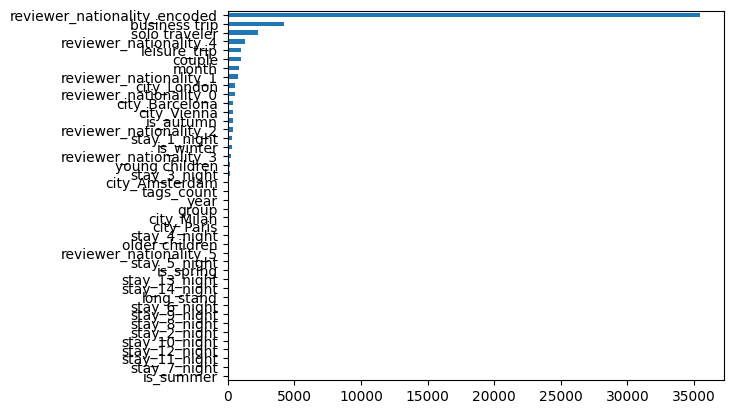

In [ ]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [ ]:
print(X.columns)

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'year', 'month', 'day', 'is_spring', 'is_summer',
       'is_autumn', 'is_winter', 'city_Amsterdam', 'city_Barcelona',
       'city_London', 'city_Milan', 'city_Paris', 'city_Vienna', 'nights',
       'stay_1_night', 'stay_2_night', 'stay_3_night', 'stay_4_night',
       'stay_5_night', 'stay_6_night', 'stay_7_night', 'stay_8_night',
       'stay_9_night', 'stay_10_night', 'stay_11_night', 'stay_12_night',
       'stay_13_night', 'stay_14_night', 'long_stand', 'leisure_trip',
       'couple', 'business trip', 'solo traveler', 'young children',
       'older children', 'group', 'reviewer_nationality_encoded', 'tags_count',
       'percent_real_review', 'reviewer_nationality_0',
       'reviewer_nationality_1', 'reviewer_natio

<Axes: >

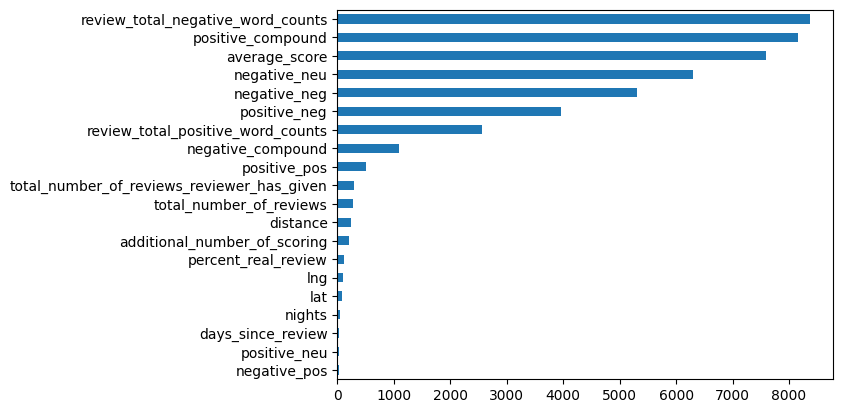

In [ ]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [ ]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [ ]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.14875614588228625
